In [37]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

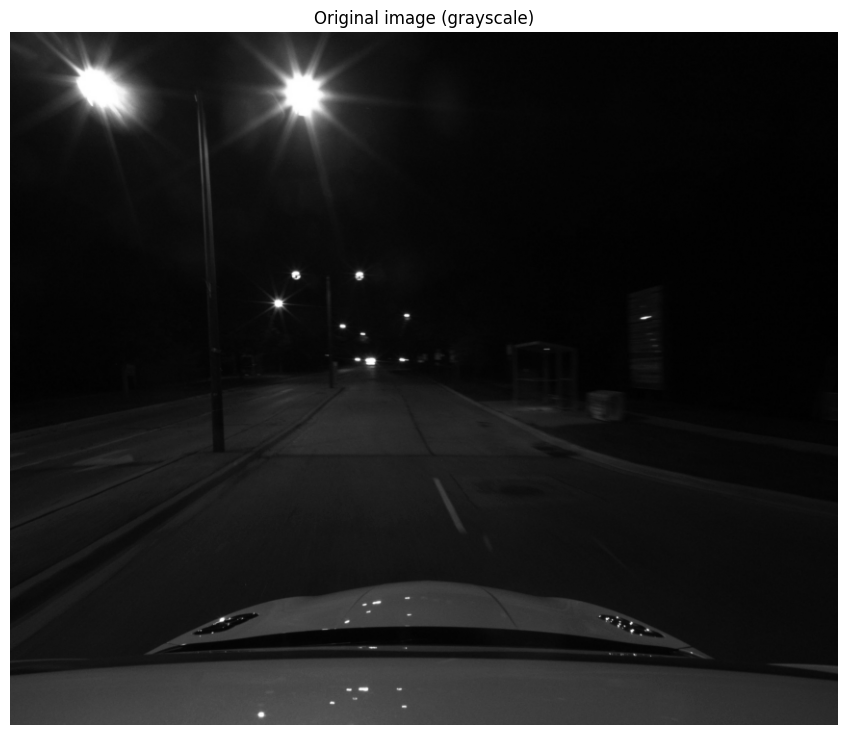

Original ORB keypoints: 975


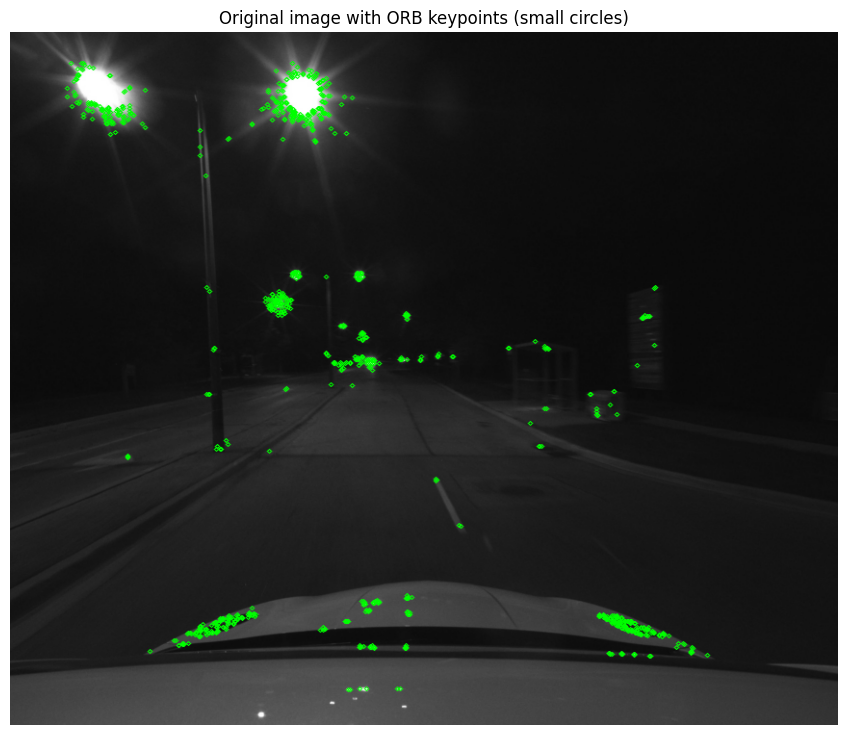

In [38]:
# Cell 2 — Load an image + detect ORB keypoints + overlay (SMALL circles)
# Change this to your image path
img_path = "1631664278933388.png"
# img_path = "1631664285533445.png"

if not os.path.exists(img_path):
    raise FileNotFoundError(f"Image not found: {img_path}")

bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
if bgr is None:
    raise ValueError(f"cv2.imread failed on: {img_path}")

gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 9))
plt.imshow(gray, cmap="gray")  # BGR->RGB for matplotlib
plt.title("Original image (grayscale)")
plt.axis("off")
plt.show()

def draw_small_circles(gray_u8, keypoints, radius=2, thickness=1):
    vis = cv2.cvtColor(gray_u8, cv2.COLOR_GRAY2BGR)
    for kp in keypoints:
        x, y = int(round(kp.pt[0])), int(round(kp.pt[1]))
        cv2.circle(vis, (x, y), radius, (0, 255, 0), thickness, lineType=cv2.LINE_AA)
    return vis

# ORB params you can tweak
orb = cv2.ORB_create(
    nfeatures=1000,
    scaleFactor=1.2,
    nlevels=8,
    edgeThreshold=31,
    patchSize=31,
    fastThreshold=7,  # try lower (5,3,1) for dark scenes
)

kps0 = orb.detect(gray, None)

vis0 = draw_small_circles(gray, kps0, radius=2, thickness=1)

print(f"Original ORB keypoints: {len(kps0)}")

plt.figure(figsize=(15, 9))
plt.imshow(vis0[..., ::-1])  # BGR->RGB for matplotlib
plt.title("Original image with ORB keypoints (small circles)")
plt.axis("off")
plt.show()


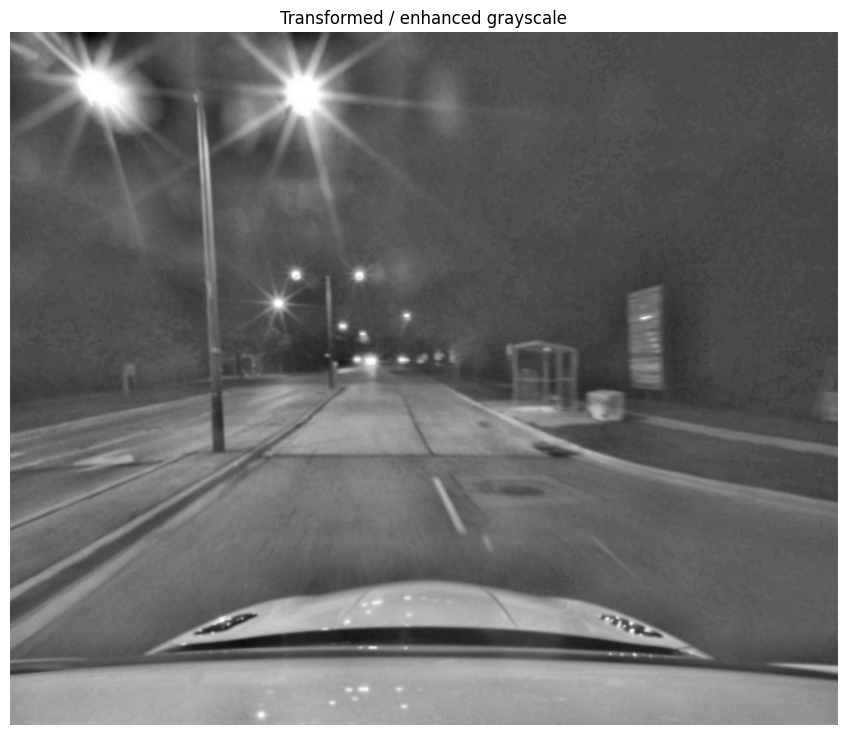

In [ ]:
# Cell 3 — Transformations / enhancement pipeline (denoise -> gamma -> CLAHE -> optional unsharp)
def apply_gamma_u8(img_u8, gamma=0.75):
    # gamma < 1 brightens shadows, gamma > 1 darkens
    img = img_u8.astype(np.float32) / 255.0
    img = np.power(np.clip(img, 0.0, 1.0), gamma)
    return (img * 255.0).astype(np.uint8)

def unsharp_mask_u8(img_u8, sigma=1.0, amount=0.5):
    blurred = cv2.GaussianBlur(img_u8, (0, 0), sigmaX=sigma, sigmaY=sigma)
    sharp = cv2.addWeighted(img_u8, 1.0 + amount, blurred, -amount, 0)
    return np.clip(sharp, 0, 255).astype(np.uint8)

# --- knobs to tweak ---
do_denoise = True
nlm_h = 5                # 3–7 is typical (higher = stronger denoise)
gamma = 0.3             # 0.6–0.85 often helpful in dark scenes
clahe_clip = 4.0         # 2–4 (too high can create noisy “fake corners”)
clahe_grid = (16, 16)      # (8,8) or (16,16)
do_unsharp = False       # turn on only if image is soft (not noisy)
unsharp_sigma = 1.0
unsharp_amount = 0.5
# ----------------------

proc = gray.copy()

if do_denoise:
    # proc = cv2.fastNlMeansDenoising(proc, None, h=nlm_h, templateWindowSize=7, searchWindowSize=21)
    proc = cv2.bilateralFilter(proc, d=5, sigmaColor=75, sigmaSpace=75)

proc = apply_gamma_u8(proc, gamma=gamma)

clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=clahe_grid)
proc = clahe.apply(proc)

if do_unsharp:
    proc = unsharp_mask_u8(proc, sigma=unsharp_sigma, amount=unsharp_amount)

plt.figure(figsize=(15, 9))
plt.imshow(proc, cmap="gray")
plt.title("Transformed / enhanced grayscale")
plt.axis("off")
plt.show()


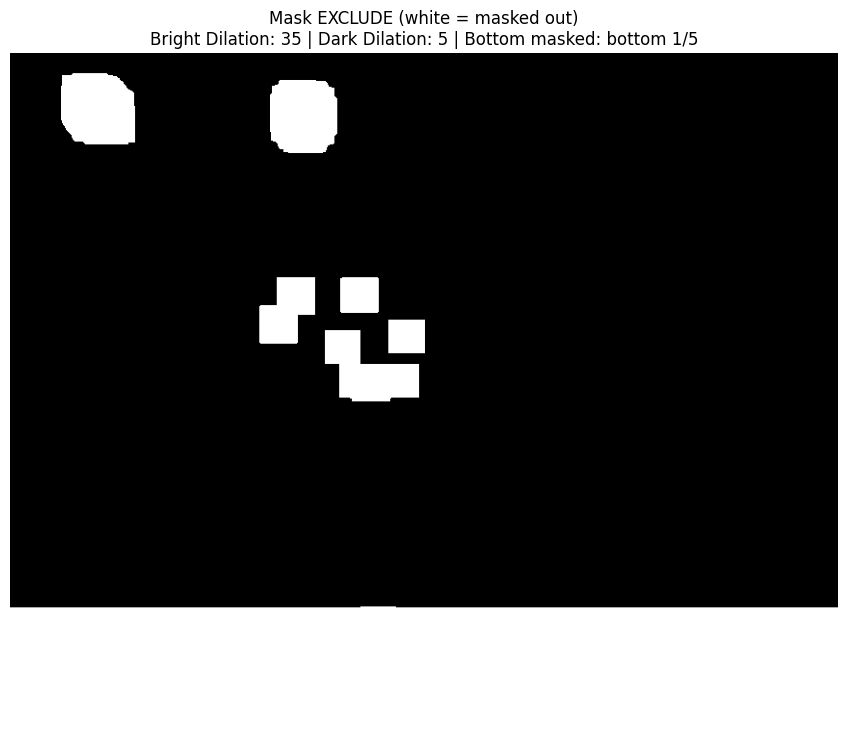

In [40]:
# Cell 3.5 — Generate + show the (exclude) mask (bright saturation + near-black)
# MODIFIED: Uses asymmetric dilation to handle light blooming vs shadows
#           Also masks out the bottom 1/5 of the image.

# 1. Thresholds
sat_thr = 250    # Threshold for bright lights (235–255)
dark_thr = 8     # Threshold for deep shadows (5–15)

# 2. Dilation settings (The major change)
# We use a much larger kernel for bright spots because streetlights create 
# large, unstable halos ("blooming") that confuse ORB.
dilate_bright_k = 35   # Aggressive exclusion around lights
dilate_dark_k = 5      # Conservative exclusion around shadows to save nearby edges

# 3. Create raw binary masks
sat = (gray >= sat_thr).astype(np.uint8) * 255
dark = (gray <= dark_thr).astype(np.uint8) * 255

# 4. Apply separate dilations
k_bright = np.ones((dilate_bright_k, dilate_bright_k), np.uint8)
k_dark   = np.ones((dilate_dark_k,   dilate_dark_k),   np.uint8)

sat  = cv2.dilate(sat,  k_bright, iterations=1)
dark = cv2.dilate(dark, k_dark,   iterations=1)

# 5. Combine into base exclusion mask
mask_exclude = cv2.bitwise_or(sat, dark)          # 255 = excluded (don't look here)

# 5.5. Also exclude the bottom 1/5 of the image
H, W = gray.shape
bottom_mask = np.zeros_like(mask_exclude, dtype=np.uint8)
bottom_start = int(4 * H / 5)                     # start of bottom 1/5
bottom_mask[bottom_start:H, :] = 255             # white band at bottom

mask_exclude = cv2.bitwise_or(mask_exclude, bottom_mask)

# Recompute keep mask after adding bottom band
mask_keep = cv2.bitwise_not(mask_exclude)         # 255 = keep (look for features here)

# Visualize masks
plt.figure(figsize=(15, 9))
plt.imshow(mask_exclude, cmap="gray")
plt.title(
    f"Mask EXCLUDE (white = masked out)\n"
    f"Bright Dilation: {dilate_bright_k} | Dark Dilation: {dilate_dark_k} | "
    f"Bottom masked: bottom 1/5"
)
plt.axis("off")
plt.show()


Processed ORB keypoints (all): 1000


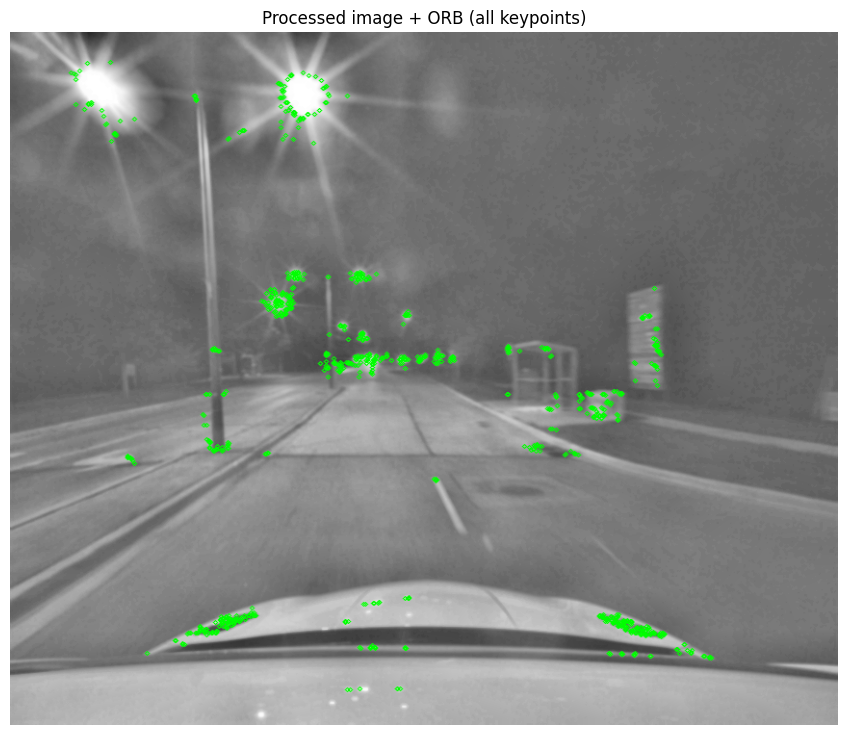

Processed ORB keypoints (filtered): 338
Removed by mask: 662


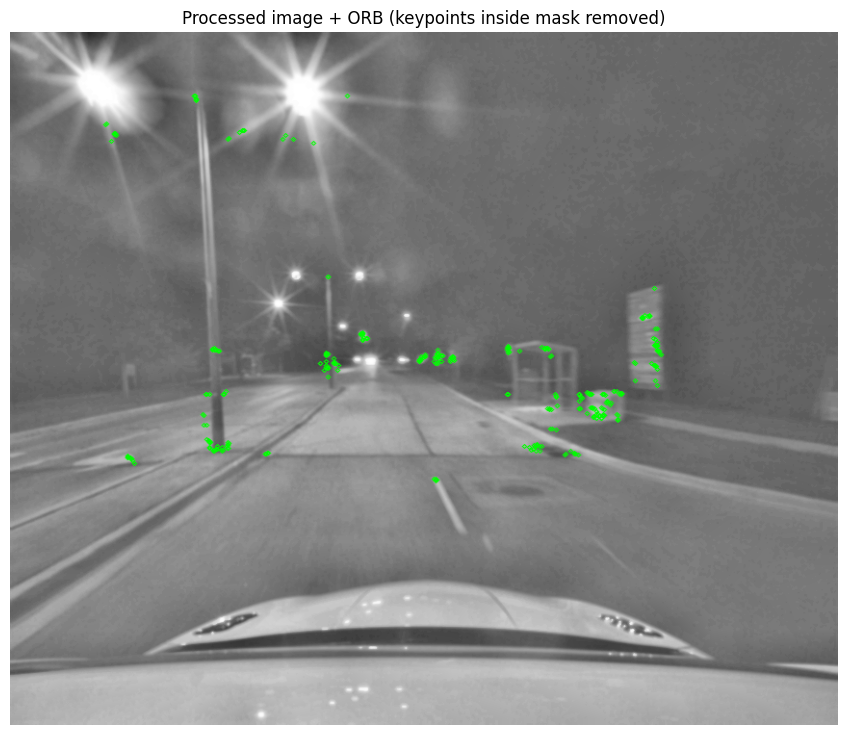

In [41]:
# Cell 4 — Detect ORB ONCE on processed image, then:
# (1) show processed + ORB (all)
# (2) show processed + ORB with points inside mask removed (NO re-detect)

orb_proc = cv2.ORB_create(
    nfeatures=1000,
    scaleFactor=1.2,
    nlevels=8,
    edgeThreshold=31,
    patchSize=31,
    fastThreshold=5,
)

# 1) Detect ONCE (no mask)
kps1_all = orb_proc.detect(proc, mask=None)

# Overlay (all)
vis1_all = draw_small_circles(proc, kps1_all, radius=2, thickness=1)
print(f"Processed ORB keypoints (all): {len(kps1_all)}")

plt.figure(figsize=(15, 9))
plt.imshow(vis1_all[..., ::-1])
plt.title("Processed image + ORB (all keypoints)")
plt.axis("off")
plt.show()

# 2) Filter OUT keypoints that fall inside excluded region (mask_exclude from Cell 3.5)
H, W = proc.shape[:2]
kps1_filtered = []
removed = 0

for kp in kps1_all:
    x, y = int(round(kp.pt[0])), int(round(kp.pt[1]))
    # guard against any rounding edge cases
    if x < 0 or x >= W or y < 0 or y >= H:
        removed += 1
        continue
    if mask_exclude[y, x] > 0:   # excluded region
        removed += 1
    else:
        kps1_filtered.append(kp)

vis1_filtered = draw_small_circles(proc, kps1_filtered, radius=2, thickness=1)
print(f"Processed ORB keypoints (filtered): {len(kps1_filtered)}")
print(f"Removed by mask: {removed}")

plt.figure(figsize=(15, 9))
plt.imshow(vis1_filtered[..., ::-1])
plt.title("Processed image + ORB (keypoints inside mask removed)")
plt.axis("off")
plt.show()
